# Árvores II - Cross Validation I

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [44]:
X_train = pd.read_csv('X_train_novo.csv', index_col=['index','individuo'])
y_train = pd.read_csv('y_train_novo.csv',index_col='Unnamed: 0')

X_test = pd.read_csv('X_test_novo.csv', index_col=['index','individuo'])
y_test = pd.read_csv('y_test_novo.csv',index_col='Unnamed: 0')

### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [45]:
SEED = 1729
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.25, random_state=SEED)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [46]:
caminho = DecisionTreeClassifier(max_depth=4,random_state=SEED).cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha).fit(X_train,y_train)
    clfs.append(clf)

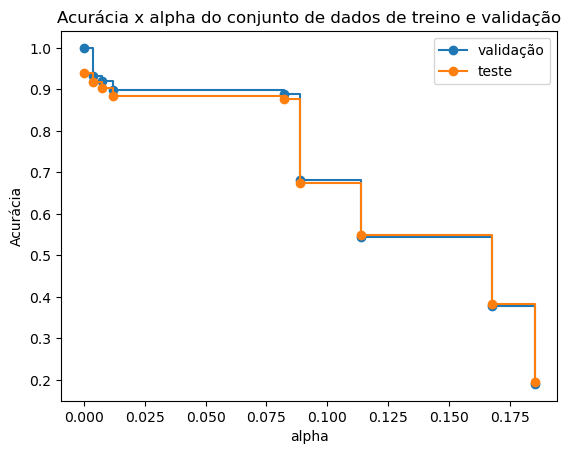

In [47]:
train_scores = [clf.score(X_train,y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [48]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 93.91


DecisionTreeClassifier(random_state=1729)

Acurácia: 86.60


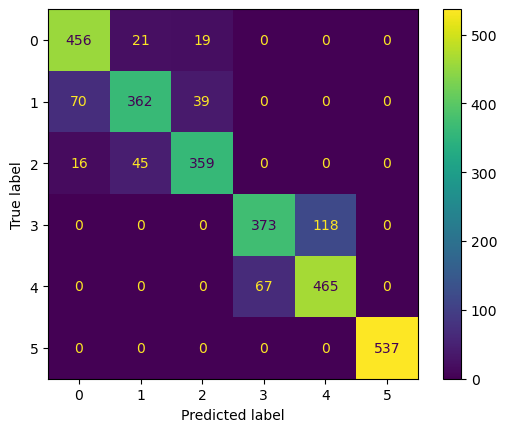

In [49]:
melhor_clf = melhor_arvore.fit(X_train,y_train)
print(f'Acurácia: {melhor_arvore.score(X_test, y_test)*100:.2f}')

predictions = melhor_arvore.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

- Melhores variáveis pela importance

In [50]:
importance = ({"feature": list(X_train.columns),
               "importance": melhor_arvore.feature_importances_})

importance_clf = pd.DataFrame(importance).sort_values("importance", ascending=False)
importance_clf.head(3)

,feature,importance
52,53 tGravityAcc-min()-X,0.240650
265,266 fBodyAcc-mean()-X,0.201696
559,"560 angle(Y,gravityMean)",0.137236


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

In [51]:
%%time
x_train =X_train.iloc[:,importance_clf[0:3].index]
x_valid = X_valid.iloc[:,importance_clf[0:3].index]

CPU times: total: 0 ns
Wall time: 0 ns


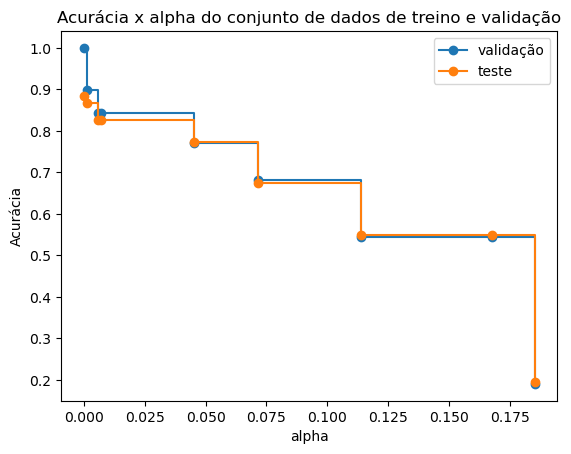

In [52]:
caminho = DecisionTreeClassifier(max_depth=4,random_state=SEED).cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha).fit(x_train,y_train)
    clfs.append(clf)
    
train_scores = [clf.score(x_train,y_train) for clf in clfs]
valid_scores = [clf.score(x_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="validação",
        drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="teste",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [53]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

Acurácia da melhor árvore na base de validação: 88.52


### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia: 71.12


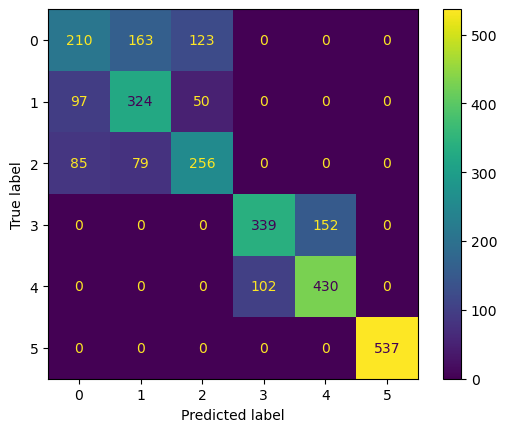

In [56]:
x_test =X_test.iloc[:,importance_clf[0:3].index]

print(f'Acurácia: {melhor_arvore.score(x_test, y_test)*100:.2f}')
#plot_confusion_matrix(melhor_arvore, x_test, y_test);

predictions_x = melhor_arvore.predict(x_test)
cm_x = confusion_matrix(y_test, predictions_x)
disp_x = ConfusionMatrixDisplay(confusion_matrix=cm_x)
disp_x.plot()
plt.show()

#### Acurácia caiu de  86,60% para 71,12%, como aprendido já é esperado.